In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
import tensorflow as tf 
from tensorflow import keras
from pathlib import Path
from tqdm import tqdm
import PIL
import matplotlib.pyplot as plt
import os
print("Imported Successfully")

Imported Successfully


In [2]:
# import each path of the image classes
glaucoma = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\glaucoma')
cataract = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\cataract')
normal = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\normal')
diabetic_retinopathy = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\diabetic_retinopathy')

In [3]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

C:\Users\swapn\OneDrive\Desktop\dataset\glaucoma:   0%|          | 0/1007 [00:00<?, ?it/s]

C:\Users\swapn\OneDrive\Desktop\dataset\normal: 100%|██████████| 1074/1074 [00:00<00:00, 1905.99it/s]
C:\Users\swapn\OneDrive\Desktop\dataset\diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 1757.75it/s]


In [4]:
df

,image,disease_type
0,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
1,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
2,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
3,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
4,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
...,...,...
4212,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4213,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4214,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4215,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3


In [5]:
df.disease_type.value_counts()

3    1098
2    1074
1    1038
0    1007
Name: disease_type, dtype: int64

In [6]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

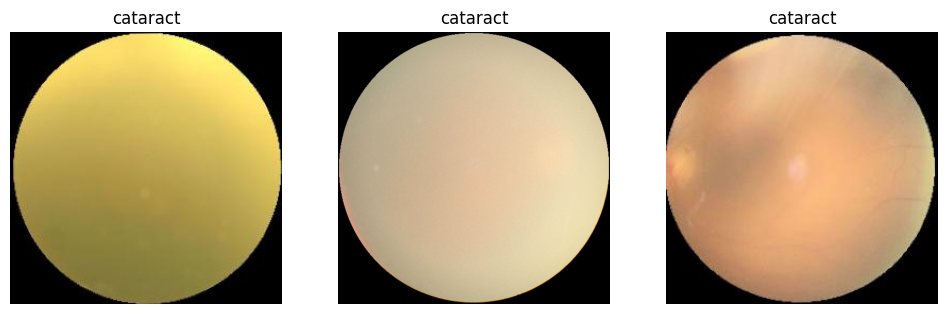

In [7]:
plot_image(1)

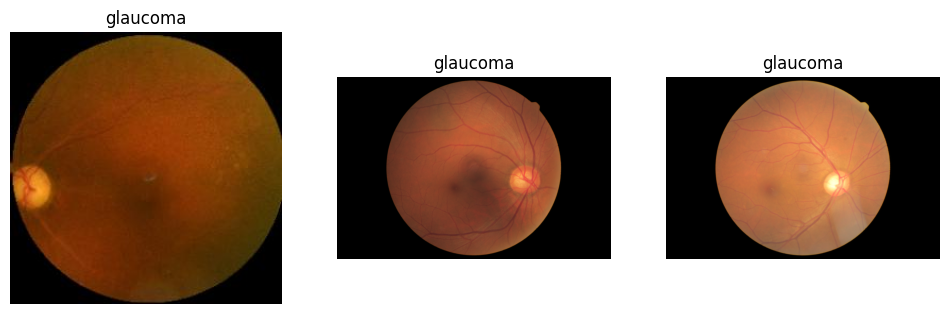

In [8]:
plot_image(0)

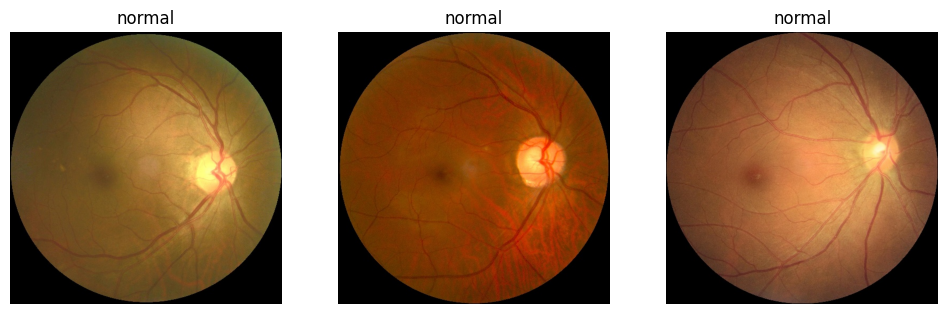

In [9]:
plot_image(2)

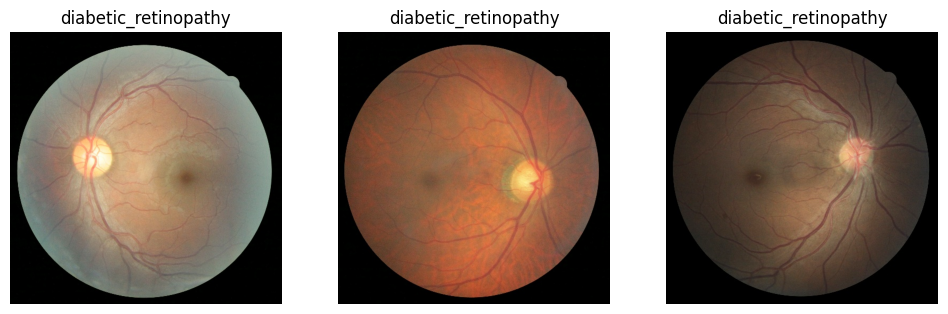

In [10]:
plot_image(3)

In [11]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: disease_type, dtype: int64

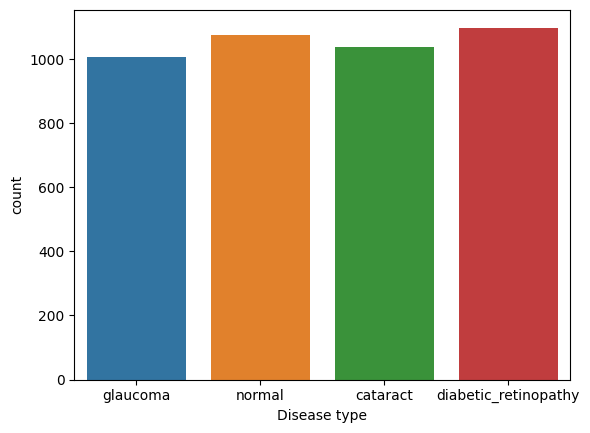

In [12]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [17]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3374 validated image filenames belonging to 4 classes.


In [19]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [22]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([ 
    layers.Rescaling(1./255, input_shape=(224,224, 3)), 
    layers.Conv2D(16, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(32, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Conv2D(64, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(), 
    layers.Flatten(), 
    layers.Dense(128, activation='relu'), 
    layers.Dense(num_classes,activation='softmax') 
]) 

In [23]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

In [24]:
# fitting the model
his = model.fit( 
  train_data,
    validation_data=valid_data, 
  epochs=15 
)

Epoch 1/15
106/106 [==============================] - 206s 2s/step - loss: 0.9469 - accuracy: 0.5880 - val_loss: 0.7013 - val_accuracy: 0.7165
Epoch 2/15
106/106 [==============================] - 45s 424ms/step - loss: 0.5906 - accuracy: 0.7481 - val_loss: 0.7334 - val_accuracy: 0.6809
Epoch 3/15
106/106 [==============================] - 44s 412ms/step - loss: 0.4981 - accuracy: 0.7988 - val_loss: 0.6124 - val_accuracy: 0.7616
Epoch 4/15
106/106 [==============================] - 43s 409ms/step - loss: 0.4170 - accuracy: 0.8408 - val_loss: 0.4849 - val_accuracy: 0.8209
Epoch 5/15
106/106 [==============================] - 46s 438ms/step - loss: 0.3900 - accuracy: 0.8397 - val_loss: 0.4797 - val_accuracy: 0.8185
Epoch 6/15
106/106 [==============================] - 47s 442ms/step - loss: 0.3341 - accuracy: 0.8651 - val_loss: 0.5310 - val_accuracy: 0.7568
Epoch 7/15
106/106 [==============================] - 47s 442ms/step - loss: 0.2892 - accuracy: 0.8906 - val_loss: 0.4746 - val_accu

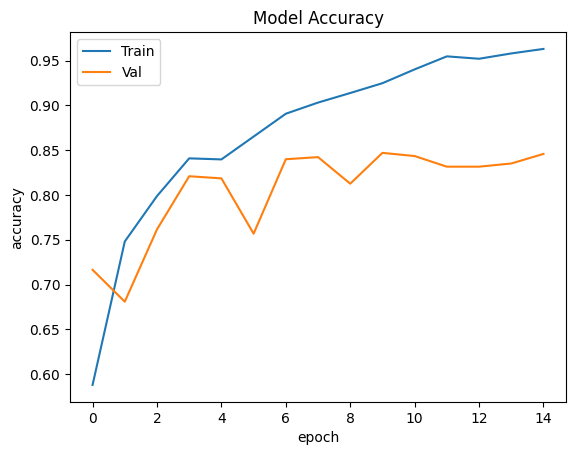

In [25]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

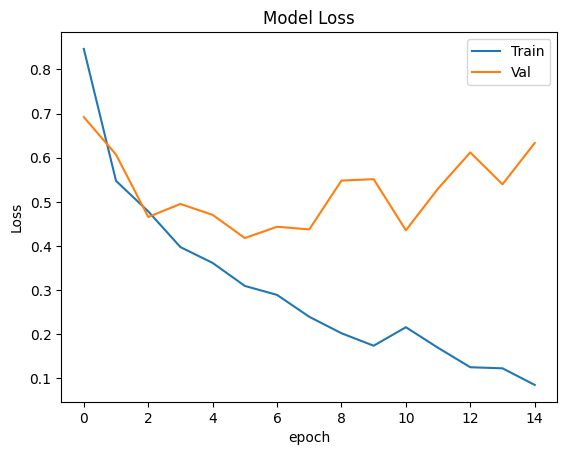

In [34]:
# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [26]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 6s 207ms/step


In [27]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.77      0.91      0.83       206
diabetic_retinopathy       0.97      1.00      0.98       201
            glaucoma       0.79      0.74      0.77       213
              normal       0.87      0.75      0.80       223

            accuracy                           0.85       843
           macro avg       0.85      0.85      0.85       843
        weighted avg       0.85      0.85      0.84       843



In [28]:
model.save("Sight-Sage.tf")

INFO:tensorflow:Assets written to: Sight-Sage.tf\assets


INFO:tensorflow:Assets written to: Sight-Sage.tf\assets


In [29]:
loaded_model = tf.keras.models.load_model('Sight-Sage.tf')

In [35]:
predictions = loaded_model.predict(valid_data)
disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
df_predict = pd.DataFrame(predictions)
max_values_per_row = df_predict.idxmax(axis=1)
m = [disease_labels[i] for i in max_values_per_row]
print(m)

27/27 [==============================] - 6s 212ms/step
['glaucoma', 'normal', 'glaucoma', 'cataract', 'glaucoma', 'glaucoma', 'glaucoma', 'diabetic_retinopathy', 'diabetic_retinopathy', 'cataract', 'diabetic_retinopathy', 'diabetic_retinopathy', 'diabetic_retinopathy', 'diabetic_retinopathy', 'diabetic_retinopathy', 'diabetic_retinopathy', 'diabetic_retinopathy', 'cataract', 'normal', 'diabetic_retinopathy', 'cataract', 'diabetic_retinopathy', 'cataract', 'glaucoma', 'normal', 'diabetic_retinopathy', 'glaucoma', 'diabetic_retinopathy', 'cataract', 'normal', 'normal', 'diabetic_retinopathy', 'cataract', 'normal', 'diabetic_retinopathy', 'diabetic_retinopathy', 'diabetic_retinopathy', 'diabetic_retinopathy', 'glaucoma', 'diabetic_retinopathy', 'cataract', 'glaucoma', 'cataract', 'diabetic_retinopathy', 'glaucoma', 'glaucoma', 'glaucoma', 'normal', 'glaucoma', 'cataract', 'cataract', 'glaucoma', 'normal', 'cataract', 'cataract', 'cataract', 'normal', 'normal', 'diabetic_retinopathy', 'dia